In [1]:
# import matplotlib.pyplot as plt
# from torchvision.io import read_image


# image = read_image("/Users/nicoletan/Downloads/nicole_oo_images/20240129_154935.png")
# mask = read_image("/Users/nicoletan/Downloads/nicole_oo_labels/20240129_154935.png")

# plt.figure(figsize=(16, 8))
# plt.subplot(121)
# plt.title("Image")
# plt.imshow(image.permute(1, 2, 0))
# plt.subplot(122)
# plt.title("Mask")
# plt.imshow(mask.permute(1, 2, 0))

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

from penn_fudan_dataset import PennFudanDataset

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [6]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [7]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [8]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('/Users/nicoletan/Documents/SMU/Y2S2/CS424/project', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training    `
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(1.0928, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1940, grad_fn=<DivBackward0>), 'loss_objectness': tensor(4.5073, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.3711, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [12]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/Users/nicoletan/Documents/SMU/Y2S2/CS424/project', get_transform(train=True))
dataset_test = PennFudanDataset('/Users/nicoletan/Documents/SMU/Y2S2/CS424/project', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 5

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

# print("That's it!")

In [13]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

Batch started
0/0: 2.154740810394287
Epoch: [0]  [ 0/66]  eta: 0:10:27  lr: 0.000082  loss: 2.1547 (2.1547)  loss_classifier: 0.7550 (0.7550)  loss_box_reg: 0.0864 (0.0864)  loss_mask: 1.2456 (1.2456)  loss_objectness: 0.0651 (0.0651)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 9.5034  data: 2.0795
Batch started
0/1: 2.5851423740386963
Batch started
0/2: 8.720545768737793
Batch started
0/3: 5.217594146728516
Batch started
0/4: 3.3787002563476562
Batch started
0/5: 1.8339194059371948
Batch started
0/6: 1.3852547407150269
Batch started
0/7: 1.2974697351455688
Batch started
0/8: 1.3657928705215454
Batch started
0/9: 4.5283637046813965
Batch started
0/10: 1.3072891235351562
Epoch: [0]  [10/66]  eta: 0:08:18  lr: 0.000850  loss: 2.1547 (3.0704)  loss_classifier: 0.5365 (0.4884)  loss_box_reg: 0.1824 (0.1821)  loss_mask: 1.1459 (1.3132)  loss_objectness: 0.1238 (0.8688)  loss_rpn_box_reg: 0.1891 (0.2179)  time: 8.9038  data: 0.1900
Batch started
0/11: 1.207674503326416
Batch started
0/12: 2.00

1/51: 1.1074728965759277
Batch started
1/52: 0.6688088178634644
Batch started
1/53: 1.109799861907959
Batch started
1/54: 0.9690996408462524
Batch started
1/55: 0.9530410170555115
Batch started
1/56: 0.7013664245605469
Batch started
1/57: 0.6219035983085632
Batch started
1/58: 0.6451242566108704
Batch started
1/59: 0.6138420701026917
Batch started
1/60: 0.5338113903999329
Epoch: [1]  [60/66]  eta: 0:00:48  lr: 0.005000  loss: 0.9530 (1.1374)  loss_classifier: 0.1463 (0.1750)  loss_box_reg: 0.1185 (0.1586)  loss_mask: 0.3608 (0.4881)  loss_objectness: 0.0576 (0.1669)  loss_rpn_box_reg: 0.0061 (0.1487)  time: 8.7569  data: 0.0011
Batch started
1/61: 1.362715244293213
Batch started
1/62: 0.7224479913711548
Batch started
1/63: 0.45069849491119385
Batch started
1/64: 0.6570546627044678
Batch started
1/65: 0.4940246641635895
Epoch: [1]  [65/66]  eta: 0:00:08  lr: 0.005000  loss: 0.7223 (1.1071)  loss_classifier: 0.1059 (0.1712)  loss_box_reg: 0.1825 (0.1638)  loss_mask: 0.3245 (0.4693)  loss

Batch started
3/34: 0.7693078517913818
Batch started
3/35: 0.5696295499801636
Batch started
3/36: 0.5272717475891113
Batch started
3/37: 0.6732190251350403
Batch started
3/38: 0.4473070800304413
Batch started
3/39: 1.4429690837860107
Batch started
3/40: 1.0194326639175415
Epoch: [3]  [40/66]  eta: 0:04:22  lr: 0.000500  loss: 0.6449 (0.8228)  loss_classifier: 0.0782 (0.1042)  loss_box_reg: 0.0992 (0.1476)  loss_mask: 0.3506 (0.3586)  loss_objectness: 0.0570 (0.0781)  loss_rpn_box_reg: 0.0076 (0.1343)  time: 9.9167  data: 0.0011
Batch started
3/41: 0.44717180728912354
Batch started
3/42: 0.5831593871116638
Batch started
3/43: 0.4637068510055542
Batch started
3/44: 1.8053317070007324
Batch started
3/45: 0.4579167068004608
Batch started
3/46: 0.4826665222644806
Batch started
3/47: 0.8678231239318848
Batch started
3/48: 0.5293020606040955
Batch started
3/49: 1.4360105991363525
Batch started
3/50: 0.46815916895866394
Epoch: [3]  [50/66]  eta: 0:02:40  lr: 0.000500  loss: 0.5832 (0.8094)  lo

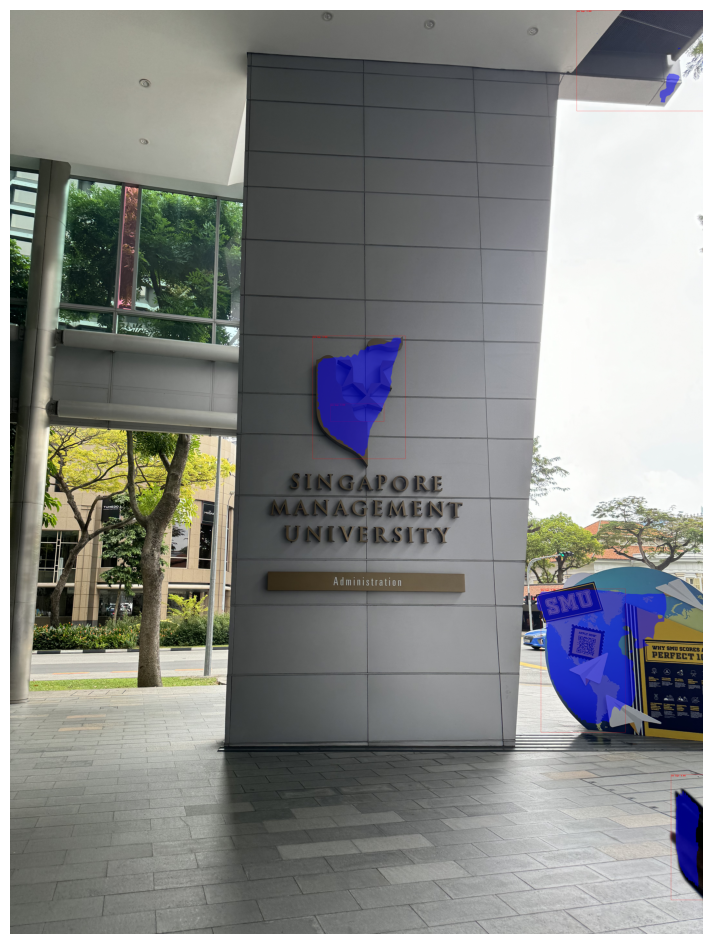

In [20]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.ops import nms
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Load the image and transform
image = read_image("/Users/nicoletan/Documents/SMU/Y2S2/CS424/project/smu_logo_jpg/img_2327.jpg")
eval_transform = get_transform(train=False)

# Set the model to evaluation mode and use it to make predictions
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device if needed
    x = x[:3, ...]  # Assuming that your eval_transform already places x on the device
    predictions = model([x, ])
    pred = predictions[0]

# Apply NMS to filter out overlapping boxes
nms_threshold = 0.1  # You can adjust this threshold
keep_boxes = nms(pred['boxes'], pred['scores'], nms_threshold)

# Filter boxes, labels, and scores according to the NMS results
pred_boxes = pred['boxes'][keep_boxes].long()
pred_scores = pred['scores'][keep_boxes]
pred_labels = pred['labels'][keep_boxes]

# Draw bounding boxes and segmentation masks on the image
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels_text = [f"smu logo: {score:.3f}" for score in pred_scores]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels_text, colors="red")

if 'masks' in pred:
    masks = (pred['masks'] > 0.7).squeeze(1)
    output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Display the image with bounding boxes and masks
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')  # Hide the axis
plt.show()
